<span style="font-size:5em;">Titanic Dataset</span>

**Michał M.**

# Introduction
This is my first Kaggle kernel. I choosed the well-known Titanic dataset, I just wanted to imporve my python skills. I am advenced R user, but have minor experience with *the snake*.

To all of you who does not know the *Titanic* dataset, it is one of the most popular Kaggle competition. The data contais information about Titanic passengers, the main objective of this task is to predict which people survived the disater.

This notebook follows four main parts:

* Data import
* Missing values imputation
* Feature analysis
* Feature engineering
* Modeling

We began with importing necessary libraries.

In [1]:
%matplotlib inline

import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

sns.set_style('whitegrid')

# Data load and initial checks

According to the provided data dictionary, variables could be descibed as follows.

| Variable |                 Definition                 |                       Key                      |
|----------|--------------------------------------------|------------------------------------------------|
| survival | Survival                                   | 0 = No, 1 = Yes                                |
| pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| sibsp    | # of siblings / spouses aboard the Titanic |                                                |
| parch    | # of parents / children aboard the Titanic |                                                |
| ticket   | Ticket number                              |                                                |
| fare     | Passenger fare                             |                                                |
| cabin    | Cabin number                               |                                                |
| embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

There are 11 independent variables.

## Data import

Data are provided in typical for Kaggle way - two datasets, *train* and *test*.

In [2]:
# load data
train = pd.read_csv('./01 Data/train.csv')
test  = pd.read_csv('./01 Data/test.csv')

# preview
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Joining train and test set

We joined *test* and *train* for an easier feature manipulation.  

In [3]:
# join train and test datasets in order to obtain the same number of features

train_len = len(train)
full_dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

## Data integrity

In [4]:
# fill empty and Nan's values with NaN
dataset = full_dataset.fillna(np.nan)

# null values
dataset.isnull().sum().sort_values(ascending=False)

Cabin          1014
Survived        418
Age             263
Embarked          2
Fare              1
Ticket            0
Parch             0
SibSp             0
Sex               0
Name              0
Pclass            0
PassengerId       0
dtype: int64

There were a lot missing values in the **cabin** column (almost 80%), what probably would make it hard to use. Missing values in **Survived** column come from the *test* dataset. There were some missing values for **Age** and we would try to fill them with more advanced method, **Embraked** and **Fare** variables could be filled using some standard approach like *mean* or *median*. 

In [5]:
train.isnull().sum().sort_values(ascending=False)

Cabin          687
Age            177
Embarked         2
Fare             0
Ticket           0
Parch            0
SibSp            0
Sex              0
Name             0
Pclass           0
Survived         0
PassengerId      0
dtype: int64

In [6]:
train.info()
train.drop(['PassengerId'], axis=1).describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Filling missing values

We handled missing values in several diffrent ways and presented it below.

## Age

Variable **Age** contains 256 missing values which should be somehow filled in order to preserve usability of **Age** variable. 

Let's look at the variables most correlated with the **Age** and its distribution among them.  

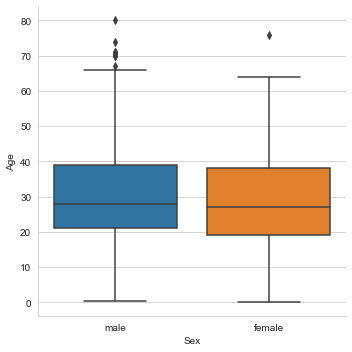

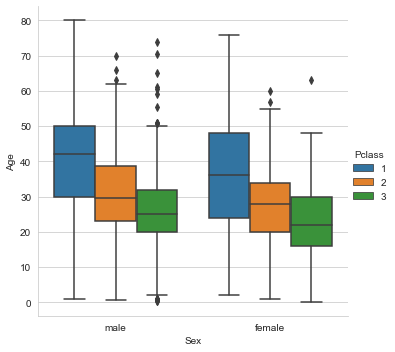

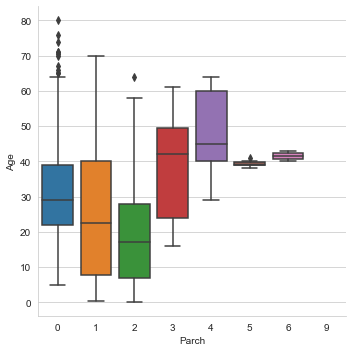

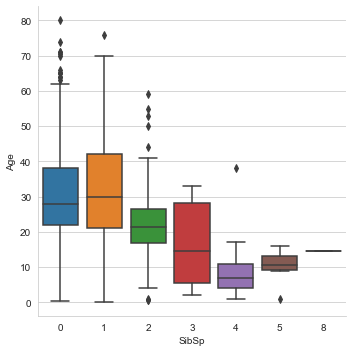

In [7]:
#  Age vs Sex, Parch, Pclass and SibSP (whole dataset)
p = sns.catplot(y='Age', x='Sex', data=dataset, kind='box')
p = sns.catplot(y='Age', x='Sex', hue='Pclass', data=dataset, kind='box')
p = sns.catplot(y='Age', x='Parch', data=dataset, kind='box')
p = sns.catplot(y='Age', x='SibSp', data=dataset, kind='box')

In [8]:
# fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# warning is showed

index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age :
    age_med = dataset['Age'].median()
    age_pred = dataset['Age'][((dataset['SibSp'] == dataset.iloc[i]['SibSp']) & (dataset['Parch'] == dataset.iloc[i]['Parch']) & (dataset['Pclass'] == dataset.iloc[i]['Pclass']))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med
        
train['Age'] = dataset.loc[:train.shape[0]-1, 'Age']

C:\Users\Michal\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


# Variables exploration

## Numerical variables

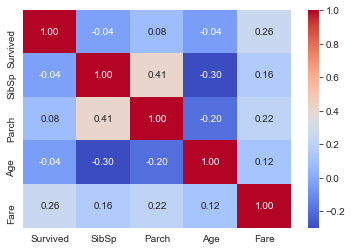

In [9]:
# correlation matrix
p = sns.heatmap(train[['Survived','SibSp','Parch','Age','Fare']].corr(), annot=True, fmt = '.2f', cmap = 'coolwarm')

There is no obvious relationship between variable **Survived** and other dependent, numerical variables.

### SibSp

*number of siblings/spouses aboard the Titanic*

The dataset defines family relations in this way:
 * Sibling = brother, sister, stepbrother, stepsister;
 * Spouse = husband, wife (mistresses and fiancés were ignored).

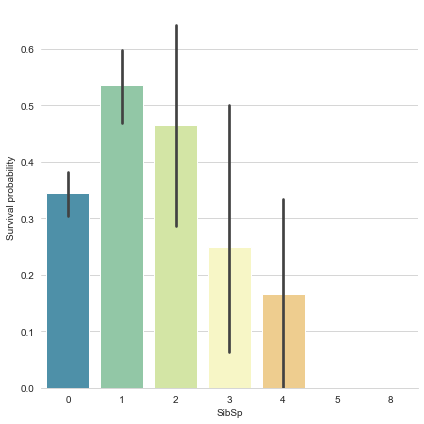

In [10]:
# SibSp vs Survived
p = sns.catplot(x='SibSp', y='Survived', data=train, kind='bar', height = 6, palette='Spectral_r')
p.despine(left=True)
p = p.set_ylabels('Survival probability')

Seems that that higher number of siblings/spouses decrease the chance of survival. As the passengers with **SibSP** equal to one, two or zero have the highest probability of survival we could suspect that being a part of large family decrease your chance of survival the disaster.

### Parch

*number of parents/children aboard the Titanic*

The dataset defines family relations in this way:
 * Parent = mother, father;
 * Child = daughter, son, stepdaughter, stepson.
 
Some children travelled only with a nanny, therefore parch=0 for them.

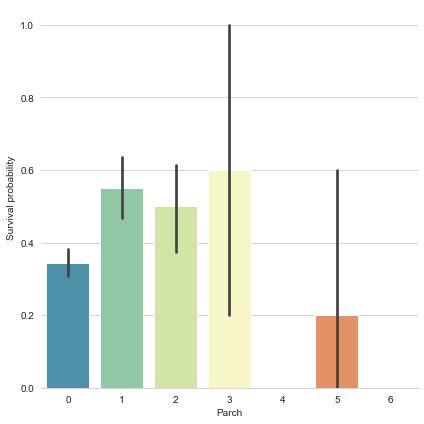

In [11]:
# Parch vs Survived
p = sns.catplot(x='Parch', y='Survived', data=train, kind='bar', height = 6, palette='Spectral_r')
p.despine(left=True)
p = p.set_ylabels('Survival probability')

There is similiar conclusion as in case of **SibSp** variable - little families (**Parch** below 3) seems to have higher probability of survival. Passengers with larger number of relatives of different generations has higher variance of **Survived** variable. 

We use this observation in a *Feature engineering* part. 

### Age

*Age in years*

Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

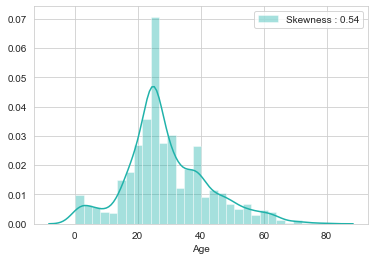

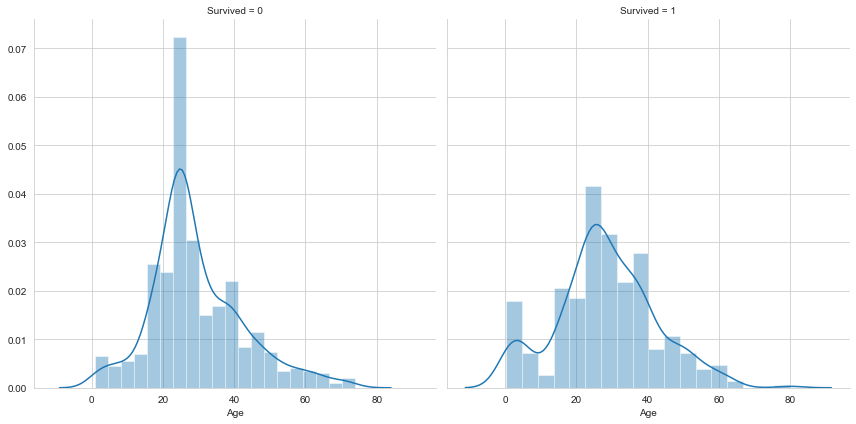

In [12]:
# Age distribution
p = sns.distplot(dataset['Age'], color='LightSeaGreen', label='Skewness : %.2f'%(dataset['Age'].skew()))
p = p.legend(loc='best')

# Age vs Survived
p = sns.FacetGrid(train, col='Survived', height = 6)
p = p.map(sns.distplot, 'Age')

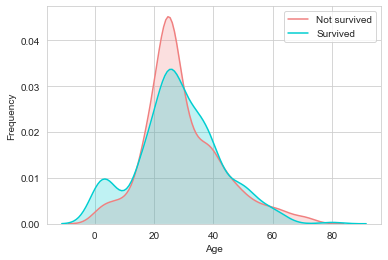

In [13]:
# comparison on single plot
p = sns.kdeplot(train['Age'][(train['Survived'] == 0) & (train['Age'].notnull())], color='lightcoral', shade=True)
p = sns.kdeplot(train['Age'][(train['Survived'] == 1) & (train['Age'].notnull())], ax=p, color='darkturquoise', shade=True)
p.set_xlabel('Age')
p.set_ylabel('Frequency')
p = p.legend(['Not survived','Survived'])

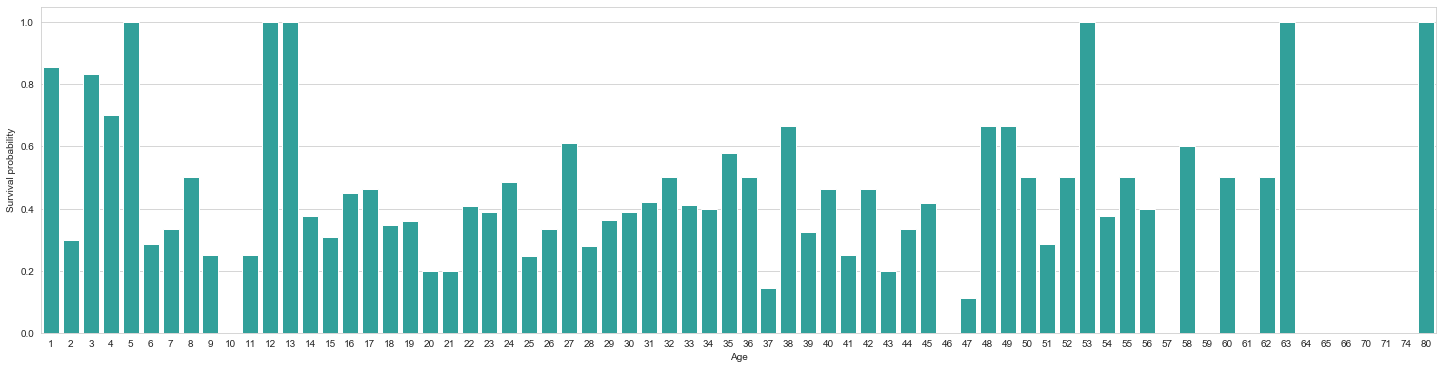

In [14]:
plt.figure(figsize=(25,6))

avg_survival_by_age = train[['Age', 'Survived']].apply(np.ceil).groupby(['Age'], as_index=False).mean()
avg_survival_by_age[['Age']] = avg_survival_by_age[['Age']].astype(int)
p = sns.barplot(x='Age', y='Survived', data=avg_survival_by_age, color='LightSeaGreen')
p = p.set_ylabel('Survival probability')

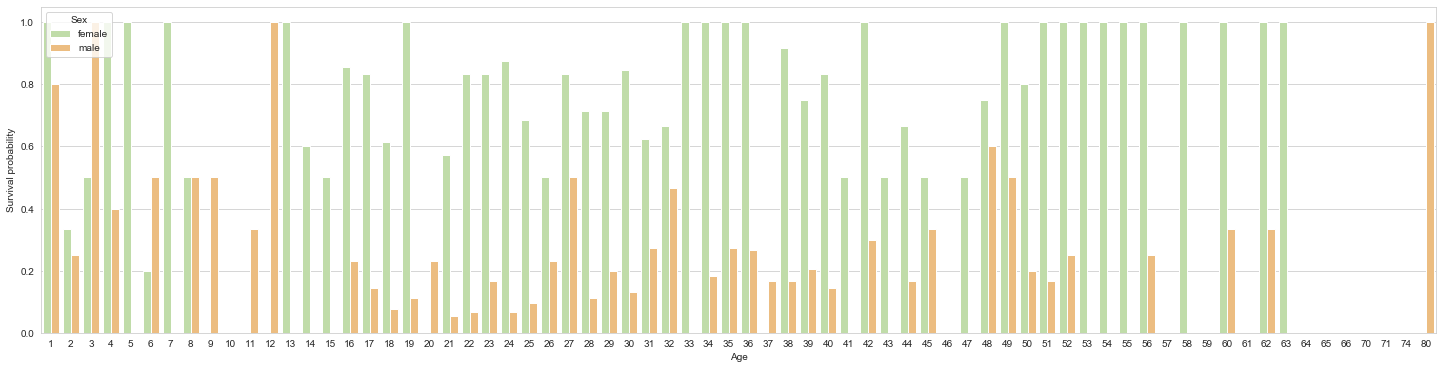

In [15]:
plt.figure(figsize=(25,6))

avg_survival_by_age = train[['Age', 'Survived', 'Sex']].apply(lambda x: np.ceil(x) if x.name == 'Age' else x).groupby(['Age', 'Sex'], as_index=False).mean()
avg_survival_by_age[['Age']] = avg_survival_by_age[['Age']].astype(int)
p = sns.barplot(x='Age', y='Survived', hue='Sex', data=avg_survival_by_age, palette='Spectral_r')
p = p.set_ylabel('Survival probability')

These two plot confirms what we know about Titanic disaster from historical sources - *Childern and ladies first!*. There is visible diffrrence among sexes in the survival probability, moreover younger passengers have a higher chance of survival in comparison to older ones.

### Fare

*Passenger fare*

Recall, there was one observation with `Null` value in the **Fare** column.

In [16]:
dataset['Fare'].isnull().sum()

1

We fill it with median value.

In [17]:
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

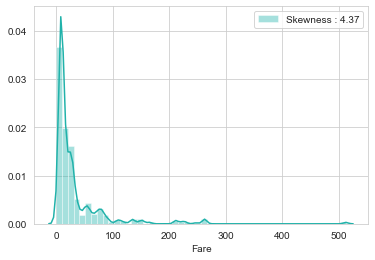

In [18]:
# Fare distribution over whole data
p = sns.distplot(dataset['Fare'], color='LightSeaGreen', label='Skewness : %.2f'%(dataset['Fare'].skew()))
p = p.legend(loc='best')

Fare distribution is very skewed, we tried to *unskew* it using logarithm.

In [19]:
# log function on Fare to reduce skewness
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
train['Fare'] = train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
test['Fare'] = test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

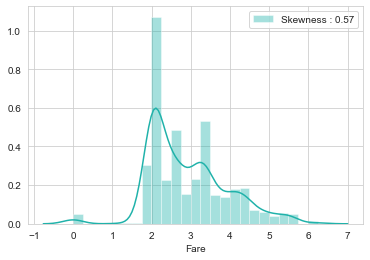

In [20]:
p = sns.distplot(dataset['Fare'], color='LightSeaGreen', label='Skewness : %.2f'%(dataset['Fare'].skew()))
p = p.legend(loc='best')

After tranformation it looks much better, no other modifications are curently needed. Let plot **Fare** variable and its distribution with relation to **Survival probability**.

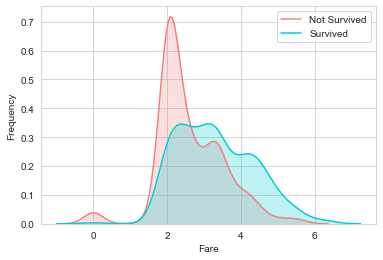

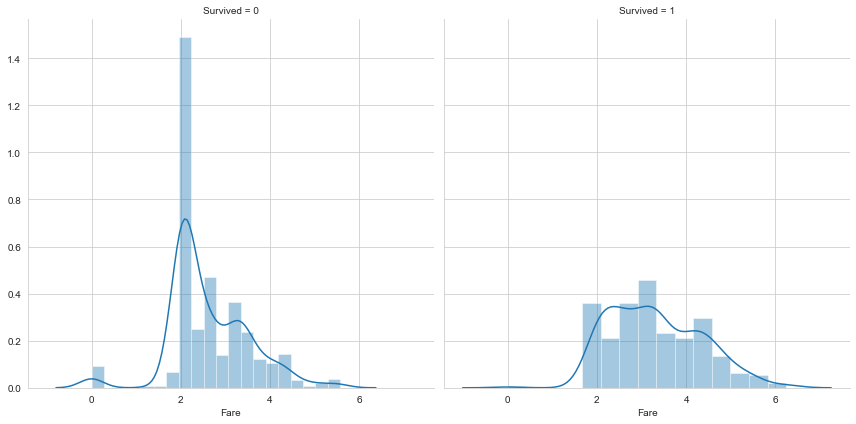

In [21]:
# comparison on single plot
p = sns.kdeplot(train['Fare'][(train['Survived'] == 0) & (train['Age'].notnull())], color='lightcoral', shade=True)
p = sns.kdeplot(train['Fare'][(train['Survived'] == 1) & (train['Age'].notnull())], ax=p, color='darkturquoise', shade=True)
p.set_xlabel('Fare')
p.set_ylabel('Frequency')
p = p.legend(['Not Survived','Survived'])

# Age vs Survived
p = sns.FacetGrid(train, col='Survived', height = 6)
p = p.map(sns.distplot, 'Fare')

There is slight, visible diffrence beetween distributions.

## Categorical Variables

Now we proceed to categorical variables and their distribution with relation to variable *Survived*

### Sex

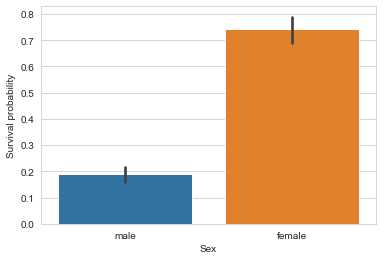

In [22]:
p = sns.barplot(x='Sex' ,y='Survived', data=train)
p = p.set_ylabel('Survival probability')

It is visible, that **sex** play import role in survival of the underlying passenger. 

In [23]:
train[['Sex','Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


#### Pclass

*Ticket class*

A proxy for socio-economic status (SES):
 * 1st = Upper
 * 2nd = Middle
 * 3rd = Lower

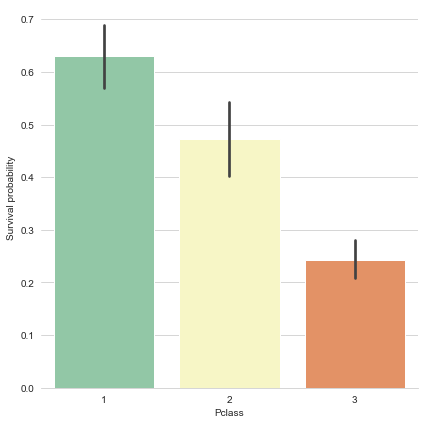

In [24]:
# Pclass vs Survived
p = sns.catplot(x='Pclass', y='Survived', data=train, kind='bar', height=6 , palette='Spectral_r')
p.despine(left=True)
p = p.set_ylabels('Survival probability')

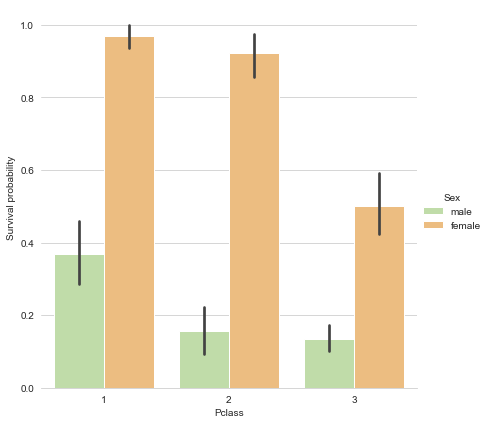

In [25]:
# Pclass vs Survived vs Sex
p = sns.catplot(x='Pclass', y='Survived', hue='Sex', data=train, height=6, kind='bar', palette='Spectral_r')
p.despine(left=True)
p = p.set_ylabels('Survival probability')

### Embarked

*Port of Embarkation*

A port of embarkation coded as:
 * C = Cherbourg;
 * Q = Queenstown;
 * S = Southampton.
 
 
 There we two observations with `Null` value in the **Embarked** column.

In [26]:
dataset['Embarked'].isnull().sum()

2

We filled it with most common value, i.e. 'S'.

In [27]:
dataset['Embarked'] = dataset['Embarked'].fillna(dataset['Embarked'].mode())

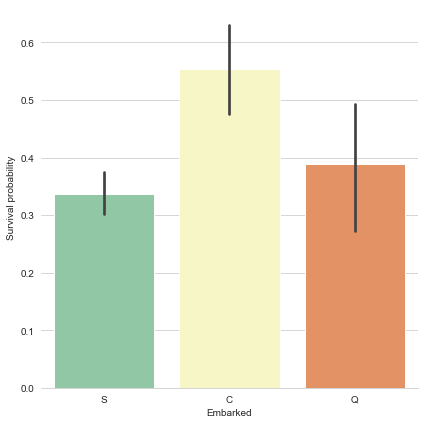

In [28]:
# Embarked vs Survived
p = sns.catplot(x='Embarked', y='Survived', data=train, kind='bar', height=6 , palette='Spectral_r')
p.despine(left=True)
p = p.set_ylabels('Survival probability')

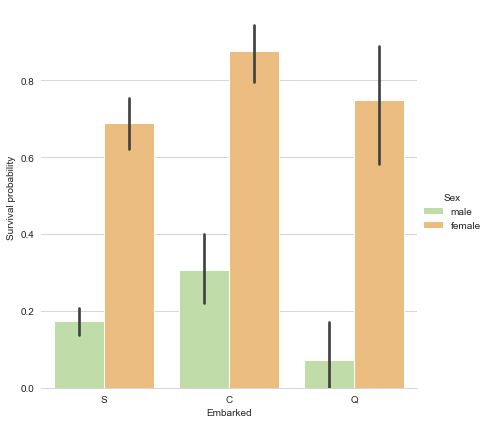

In [29]:
# Embarked vs Survived vs Sex
p = sns.catplot(x='Embarked', y='Survived', hue='Sex', data=train, height=6, kind='bar', palette='Spectral_r')
p.despine(left=True)
p = p.set_ylabels('Survival probability')

It seems that passenger coming from Cherbourg have more chance to survive.

Let's check proportion of classes among all three ports.

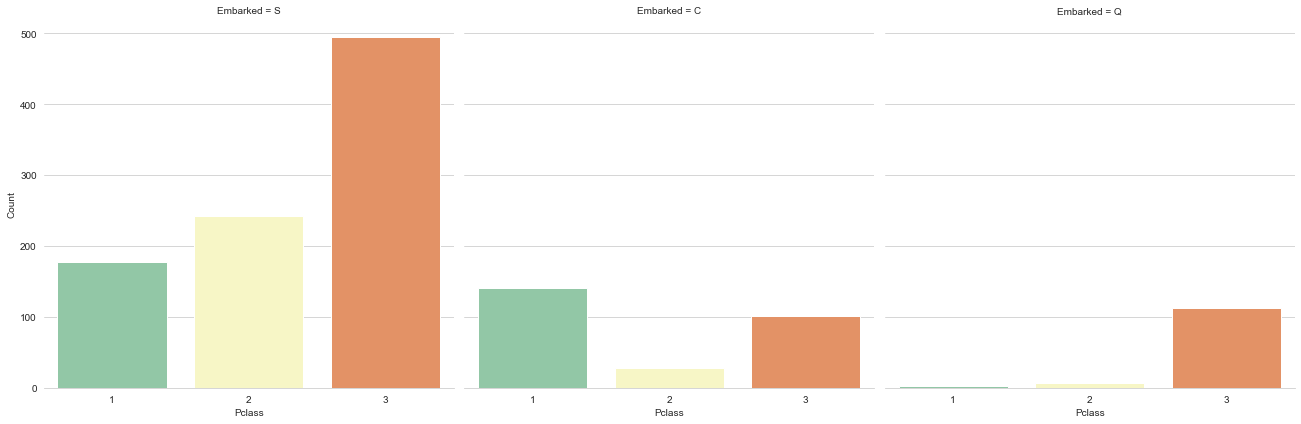

In [30]:
# Pclass vs Embarked 
p = sns.catplot('Pclass', col='Embarked', data=dataset, height=6, kind='count', palette='Spectral_r')
p.despine(left=True)
p = p.set_ylabels('Count')

We can conclude that the third class is the most frequent for passenger coming from Southampton and Queenstown, whereas Cherbourg passengers are mostly in first class which have the highest survival rate.

We can't explain why first class has an higher survival rate. Probably first class passengers were prioritised during the evacuation due to their influence.

# Feature engineering

## Family size

According to the Kaggle data dictionary, both **SibSp** and **Parch** relate to traveling with family. We can combine both to introduce variable **Family size**, deonted **FamS**. We suppose that large families might be hard to be rescued during disaster. 

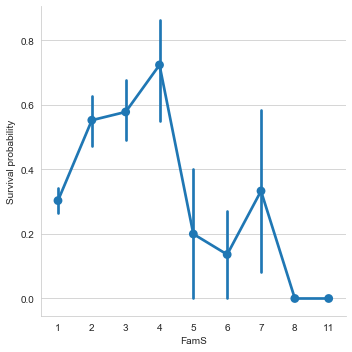

In [31]:
# family size descriptor from SibSp and Parch
dataset['FamS'] = dataset['SibSp'] + dataset['Parch'] + 1
train['FamS'] = train['SibSp'] + train['Parch'] + 1

p = sns.catplot(x='FamS', y='Survived', data = train, kind = 'point')
p = p.set_ylabels('Survival probability')

We add additional categorical variable to aggregate family size.

In [32]:
# Create new feature of family size
def family_size(peers):
    size = 'Large'
    if peers == 1:
        size = 'Single'
    elif peers <= 3:
        size = 'Small'
    elif peers == 4:
        size = 'Medium'
    return size

dataset['FamSCat'] = dataset['FamS'].map(family_size)
train['FamSCat'] = train['FamS'].map(family_size)

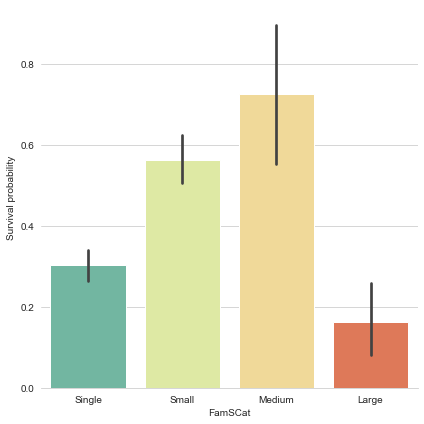

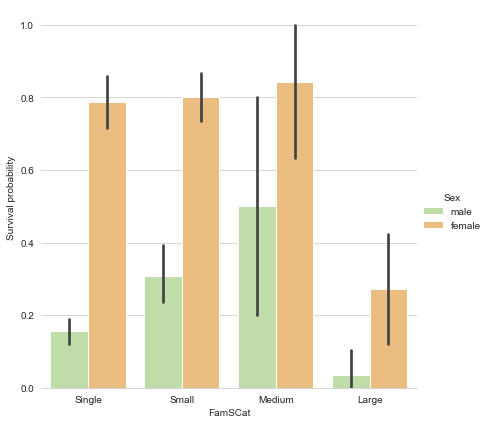

In [33]:
# FamSCat vs Survived
p = sns.catplot(x='FamSCat', y='Survived', data=train, height=6, kind='bar', palette='Spectral_r', order=['Single', 'Small', 'Medium', 'Large'])
p.despine(left=True)
p = p.set_ylabels('Survival probability')

# FamSCat vs Survived vs Sex
p = sns.catplot(x='FamSCat', y='Survived', hue='Sex', data=train, height=6, kind='bar', palette='Spectral_r', order=['Single', 'Small', 'Medium', 'Large'])
p.despine(left=True)
p = p.set_ylabels('Survival probability')

Obtained variable migh be usefull during forecasting as there is visible diffrence among the groups.

## Title

We try to extract title from the **Name** colum.

In [34]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [35]:
# Title from Name
dataset['Title'] = [i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

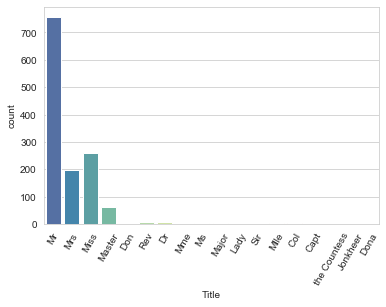

In [36]:
p = sns.countplot(x='Title', data=dataset, palette='Spectral_r')
p = plt.setp(p.get_xticklabels(), rotation=60) 

In [37]:
# convert to categorical values 
dataset['Title'] = dataset['Title'].replace(['Lady', 'the Countess', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset['Title'] = dataset['Title'].replace(['Miss', 'Ms', 'Mme', 'Mlle', 'Mrs'], 'Ladys_title')
dataset['Title'].head()

0             Mr
1    Ladys_title
2    Ladys_title
3    Ladys_title
4             Mr
Name: Title, dtype: object

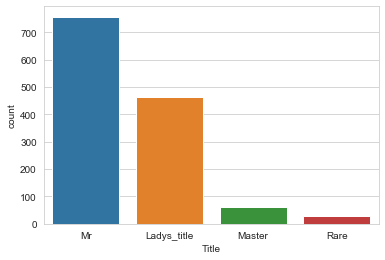

In [38]:
p = sns.countplot(dataset['Title'])

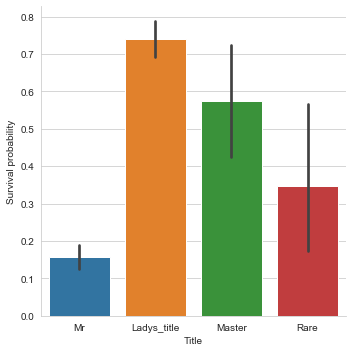

In [39]:
p = sns.catplot(x='Title', y='Survived', data=dataset, kind='bar')
p = p.set_ylabels('Survival probability')

# Modelling 

## Dummy variables/train set preparation

Before start of modelling we create dummy variables for all categorical variables we had in the dataset.

In [40]:
dataset.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'FamS', 'FamSCat',
       'Title'],
      dtype='object')

In [41]:
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset_final = pd.get_dummies(dataset.drop(labels=['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=False), prefix=['Pclass', 'Sex','Embarked', 'FamSCat', 'Title'])
dataset_final.head()

,Survived,Age,SibSp,Parch,Fare,FamS,Pclass_1,Pclass_2,Pclass_3,Sex_female,...,Embarked_Q,Embarked_S,FamSCat_Large,FamSCat_Medium,FamSCat_Single,FamSCat_Small,Title_Ladys_title,Title_Master,Title_Mr,Title_Rare
0,0.0,22.0,1,0,1.981001,2,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0
1,1.0,38.0,1,0,4.266662,2,1,0,0,1,...,0,0,0,0,0,1,1,0,0,0
2,1.0,26.0,0,0,2.070022,1,0,0,1,1,...,0,1,0,0,1,0,1,0,0,0
3,1.0,35.0,1,0,3.972177,2,1,0,0,1,...,0,1,0,0,0,1,1,0,0,0
4,0.0,35.0,0,0,2.085672,1,0,0,1,0,...,0,1,0,0,1,0,0,0,1,0


In [42]:
train_final = dataset_final.loc[:train.shape[0]-1, ]
test_final = dataset_final.loc[train.shape[0]:, ]

In [43]:
(test_final.shape[0] == test.shape[0]) & (train_final.shape[0] == train.shape[0])

True

In [44]:
# ignore warning
test_final.drop(labels=['Survived'], axis=1, inplace=True) 

C:\Users\Michal\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [45]:
train_final['Survived'] = train_final['Survived'].astype(int)

Y_train = train_final['Survived']
X_train = train_final.drop(labels = ['Survived'], axis = 1)

C:\Users\Michal\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Fast modelling

We will present different approaches to model fitting. At first we fit simple models without any additional steps, later we add scaling and in the last approach we also add *PCA*

The general pipeline for modeling looks as follows:

*scaler* → *PCA* → *ML algorithm*.

In [46]:
# CV
kfold = StratifiedKFold(n_splits=10)

#scaler
scaler = StandardScaler()

In [47]:
# aggregated testing
random_state = 2137

classifiers = []
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(QuadraticDiscriminantAnalysis())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())
classifiers.append(GaussianProcessClassifier(random_state=random_state))
classifiers.append(XGBClassifier(random_state=random_state))

In [48]:
cv_results = []

for classifier in classifiers:
    cv_results.append(cross_val_score(Pipeline([('scaler', StandardScaler()),
                                                ('classifier', classifier)]), X_train, y=Y_train, scoring='accuracy', cv=kfold, n_jobs=-1))      

cv_means = []
cv_std = []

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({'Algorithm':['RandomForest', 
                                    'AdaBoost',
                                    'GradientBoosting',
                                    'ExtraTrees',
                                    'LDA',
                                    'QDA',
                                    'LogisticRegression',
                                    'kNN',
                                    'DecisionTree',
                                    'MultipleLayerPerceptron',
                                    'SVC',
                                    'GaussianNB',
                                    'GaussianProcess',
                                    'XGBoost'
                                   ], 
                       'CrossValMeans':cv_means, 'CrossValErrors':cv_std})

In [49]:
cv_res.sort_values(by=['CrossValMeans'], ascending=False, inplace=True)
cv_res.reset_index(drop=True, inplace=True)
cv_res

,Algorithm,CrossValMeans,CrossValErrors
0,GradientBoosting,0.830549,0.040855
1,LDA,0.830524,0.033512
2,LogisticRegression,0.827166,0.032991
3,MultipleLayerPerceptron,0.818240,0.035781
4,SVC,0.817066,0.035508
5,XGBoost,0.814856,0.049360
6,GaussianNB,0.811473,0.025797
7,RandomForest,0.808152,0.042332
8,GaussianProcess,0.806979,0.037750
9,kNN,0.804769,0.046082


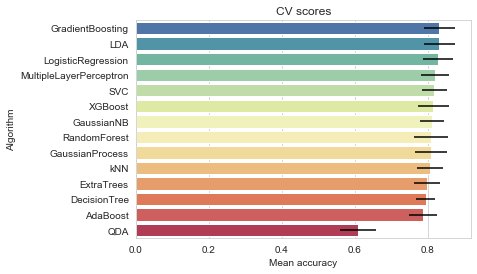

In [50]:
p = sns.barplot('CrossValMeans', 'Algorithm', data=cv_res, palette='Spectral_r',orient='h', **{'xerr':cv_std})
p.set_xlabel('Mean accuracy')
p = p.set_title('CV scores')

We choose the LDA, Logistic regression, MLP, and the Gradient boosting classifiers for the further tunning and ensamble modeling modeling. 
We also choose SVM just to check whether we are be able to tunning it well.

## (Hyper)parameter tunning

We would perform grid search to find best hyperparameters for all algorithms.

### Random forest

In [51]:
# RF tunning 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=18,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

# search grid for optimal parameters
rf_param_grid = {'classifier__n_estimators' :[50, 100, 150, 200, 250],
                 'classifier__max_depth': [None, 5, 10],       
                 'classifier__min_samples_split': [2, 4, 8, 12, 16, 20], 
                 'classifier__min_samples_leaf': [1, 5, 10, 15, 20], 
                 'classifier__min_weight_fraction_leaf': [0.0, 0.1],
                 'classifier__max_features': ['auto', 'log2', 1, 3, 5],   
                 'classifier__bootstrap': [True] # True, False
                }


gs_rf = GridSearchCV(Pipeline([('scaler', StandardScaler()),
                               ('classifier', RandomForestClassifier())]),
                     param_grid=rf_param_grid, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)

gs_rf.fit(X_train, Y_train)

rf_best = gs_rf.best_estimator_

# best score
gs_rf.best_score_

Fitting 10 folds for each of 2880 candidates, totalling 28800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 666 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 1016 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done 1466 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2016 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2666 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 3416 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 4266 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 5216 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 6266 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 7416 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 8666 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 10016 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 11466 tasks     

0.8417727840199751

In [52]:
rf_best[1]

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=18,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### AdaBoost

In [53]:
# AdaBoost tunning 

# search grid for optimal parameters
ada_param_grid = {"classifier__n_estimators" :[50, 100, 150],
                  "classifier__learning_rate":  [0.05, 0.1, 0.25, 0.5, 1, 1.5]
                 }


gs_ada = GridSearchCV(Pipeline([('scaler', StandardScaler()),
                                ('classifier', AdaBoostClassifier())]),
                     param_grid=ada_param_grid, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)

gs_ada.fit(X_train, Y_train)

ada_best = gs_ada.best_estimator_

# best score
gs_ada.best_score_

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   10.2s finished


0.8260424469413234

In [54]:
ada_best[1]

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=100, random_state=None)

### AdaBoost + optimal RF

### Gradient boosting

In [55]:
# AdaBoost tunning 

gs_ada_rf = GridSearchCV(Pipeline([('scaler', StandardScaler()),
                                   ('classifier', AdaBoostClassifier(rf_best[1]))]),
                         param_grid=ada_param_grid, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)

gs_ada_rf.fit(X_train, Y_train)

ada_rf_best = gs_ada_rf.best_estimator_

# best score
gs_ada_rf.best_score_

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 24.6min finished


0.8316978776529338

In [622]:
np.logspace(1, 10, 5, base=0.5)
np.linspace(10, 20, 3)


array([10., 15., 20.])

In [57]:
# gradient boosting tunning

gb_param_grid = {'classifier__learning_rate' :[0.1, 0.25],
                 'classifier__n_estimators' :[50, 100, 150],
                 'classifier__min_samples_split': [2, 4, 18, 16], 
                 'classifier__min_samples_leaf': [1, 5, 10, 15], 
                 'classifier__min_weight_fraction_leaf': [0.0, 0.1],
                 'classifier__max_depth': [3, 5, 10],       
                 'classifier__max_features': ['auto', 'log2', 1, 3, 5]
                }

gs_gb = GridSearchCV(Pipeline([('scaler', StandardScaler()),
                               ('classifier', GradientBoostingClassifier())]),
                     param_grid=gb_param_grid, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)

gs_gb.fit(X_train, Y_train)

gb_best = gs_gb.best_estimator_

# best score
gs_gb.best_score_

Fitting 10 folds for each of 2880 candidates, totalling 28800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 2452 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3552 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 4852 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 6352 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 8052 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 9800 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 10850 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 12000 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 13250 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 14600 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 16050 tasks  

0.845143570536829

In [58]:
gb_best[1]

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features='auto', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=5, min_samples_split=18,
                           min_weight_fraction_leaf=0.0, n_estimators=150,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### Extra-trees

In [59]:
# Extra-trees tunning

et_param_grid = {'classifier__n_estimators' :[50, 100, 150],
                 'classifier__max_depth': [None, 5, 10],       
                 'classifier__min_samples_split': [2, 4, 18, 16], 
                 'classifier__min_samples_leaf': [1, 5, 10, 15], 
                 'classifier__min_weight_fraction_leaf': [0.0, 0.1],
                 'classifier__max_features': ['auto', 'log2', 1, 3, 5],   
                 'classifier__bootstrap': [True, False]    # True, False             
                }

gs_et = GridSearchCV(Pipeline([('scaler', StandardScaler()),
                               ('classifier', ExtraTreesClassifier())]),
                     param_grid=et_param_grid, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)

gs_et.fit(X_train, Y_train)

et_best = gs_et.best_estimator_

# best score
gs_et.best_score_

Fitting 10 folds for each of 2880 candidates, totalling 28800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   59.8s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

0.8361423220973782

In [60]:
et_best[1]

ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=5, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=5, min_samples_split=4,
                     min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

### LDA

In [61]:
# LDA tunning

lda_param_grid = {'classifier__shrinkage': np.linspace(0, 1, 11)}

gs_lda = GridSearchCV(Pipeline([('scaler', StandardScaler()),
                               ('classifier', LinearDiscriminantAnalysis(solver='lsqr'))]),
                      param_grid=lda_param_grid, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)

gs_lda.fit(X_train, Y_train)

lda_best = gs_lda.best_estimator_

# best score
gs_lda.best_score_

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    0.3s finished


0.8339076154806492

In [62]:
lda_best[1]

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=0.5,
                           solver='lsqr', store_covariance=False, tol=0.0001)

### QDA

In [63]:
# QDA tunning

qda_param_grid = {'classifier__reg_param': np.linspace(0, 1, 11)}

gs_qda = GridSearchCV(Pipeline([('scaler', StandardScaler()),
                                ('classifier', QuadraticDiscriminantAnalysis(tol=1.0e-15))]),
                      param_grid=qda_param_grid, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)

gs_qda.fit(X_train, Y_train)

qda_best = gs_qda.best_estimator_

# best score
gs_qda.best_score_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    0.3s finished


0.827191011235955

In [64]:
qda_best[1]

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.9,
                              store_covariance=False, tol=1e-15)

###  Logistic regression

In [65]:
# Logistic regression tunning

lr_param_grid = {'classifier__C': np.linspace(0, 1, 11),      
                 'classifier__l1_ratio': np.linspace(0, 1, 11)
                }

gs_lr = GridSearchCV(Pipeline([('scaler',  StandardScaler()),
                               ('classifier', LogisticRegression(penalty='elasticnet',
                                                                 solver='saga'))]), 
                     param_grid=lr_param_grid, cv=kfold, scoring="accuracy", n_jobs=-1, verbose=1)

gs_lr.fit(X_train, Y_train)

lr_best = gs_lr.best_estimator_

# best score
gs_lr.best_score_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 121 candidates, totalling 1210 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1210 out of 1210 | elapsed:   14.2s finished


0.8316479400749064

In [66]:
lr_best[1]

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.5, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

### kNN

In [67]:
# kNN classifier tunning

knn_param_grid = {'classifier__n_neighbors': np.arange(1, 25),   
                  'classifier__p': np.arange(1, 3)              
                 }

gs_knn = GridSearchCV(Pipeline([('scaler',  StandardScaler()),
                                ('classifier', KNeighborsClassifier())]),
                      param_grid=knn_param_grid, cv=kfold, scoring="accuracy", n_jobs=-1, verbose=1)

gs_knn.fit(X_train, Y_train)

knn_best = gs_knn.best_estimator_

# best score
gs_knn.best_score_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    2.0s finished


0.826067415730337

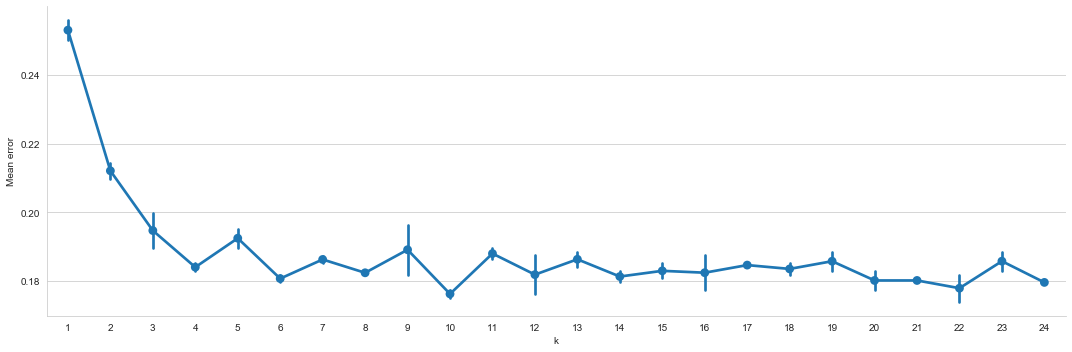

In [68]:
knn_cv_results = pd.DataFrame(gs_knn.cv_results_)
knn_cv_results['Mean error'] = 1 - knn_cv_results['mean_test_score']


p = sns.catplot(x='param_classifier__n_neighbors', y='Mean error', data=knn_cv_results, kind='point', aspect=3)
p = p.set_xlabels('k')

In [69]:
knn_best[1].n_neighbors = 10
knn_best[1]

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=1,
                     weights='uniform')

### Decision tree

In [70]:
# decision tree tunning

dt_param_grid = {'classifier__max_depth': [None, 5, 10],       
                 'classifier__min_samples_split': [2, 4, 18, 16], 
                 'classifier__min_samples_leaf': [1, 5, 10, 15], 
                 'classifier__min_weight_fraction_leaf': [0.0, 0.1],
                 'classifier__max_features': ['auto', 'log2', 1, 3, 5],   
                }            

gs_dt = GridSearchCV(Pipeline([('scaler',  StandardScaler()),
                               ('classifier', DecisionTreeClassifier())]),
                      param_grid=dt_param_grid, cv=kfold, scoring="accuracy", n_jobs=-1, verbose=1)

gs_dt.fit(X_train, Y_train)

dt_best = gs_dt.best_estimator_

# best score
gs_dt.best_score_

Fitting 10 folds for each of 480 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:    9.0s finished


0.8417852684144819

In [71]:
dt_best[1]

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=16,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

### MLP

In [72]:
# multilayer perceptron tunning

nn_param_grid = {'classifier__hidden_layer_sizes': [(100, ), (90, ), (80, ), (70, ), (60, ), 
                                                    (50, ), (40, ), (35, ), (30, ), (25, )],
                 'classifier__activation': ['logistic', 'tanh', 'relu']
                }

gs_nn = GridSearchCV(Pipeline([('scaler',  StandardScaler()),
                               ('classifier', MLPClassifier(solver='adam',
                                                            max_iter=600))]), 
                     param_grid=nn_param_grid, cv=kfold, scoring="accuracy", n_jobs=-1, verbose=1)

gs_nn.fit(X_train, Y_train)

nn_best = gs_nn.best_estimator_

# best score
gs_nn.best_score_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   31.1s finished


0.8327840199750313

In [73]:
nn_best[1]

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(70,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=600,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

### SVM  

In [74]:
# SVM classifier tunning

svm_param_grid = {'classifier__C': np.arange(1, 200, 25),             # 1, 25, 50, 75, 100, 125, 250, 500, 100
                  'classifier__gamma': np.logspace(1, 10, 10, base=0.5)
                 }

gs_svm = GridSearchCV(Pipeline([('scaler',  StandardScaler()),
                                ('classifier', SVC())]),
                      param_grid=svm_param_grid, cv=kfold, scoring="accuracy", n_jobs=-1, verbose=1)

gs_svm.fit(X_train,Y_train)

svm_best = gs_svm.best_estimator_

# best score
gs_svm.best_score_

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 785 out of 800 | elapsed:   12.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:   12.9s finished


0.8316604244694131

In [75]:
svm_best[1]

SVC(C=26, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.00390625, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### XGBoost

In [76]:
# XGBoost classifier tunning

xgb_param_grid = {'classifier__min_child_weight': np.arange(1, 15, 3), 
                  'classifier__gamma': np.arange(0, 8, 0.5), # 0.5, 1, 1.5, 2, 4, 4.5, 5, 5.5, 6
                  'classifier__subsample': np.linspace(0, 1, 5), # 0.6, 0.8, 0.9, 1.0, 
                  'classifier__colsample_bytree': np.linspace(0.5, 1, 6), # 0.6, 0.7, 0.8, 0.9, 1
                  'classifier__max_depth': np.arange(2, 10, 2) # 3, 4, 5, 6, 7, 8
                 }

gs_xgb = GridSearchCV(Pipeline([('scaler',  StandardScaler()),
                                ('classifier', XGBClassifier())]),
                      param_grid=xgb_param_grid, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)

gs_xgb.fit(X_train, Y_train)

xgb_best = gs_xgb.best_estimator_

# best score
gs_xgb.best_score_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 9600 candidates, totalling 96000 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 2452 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 3552 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done 4852 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 6352 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 8052 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 9952 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 12052 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 14352 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 16852 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 19552 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 22452 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 25552 tasks      | elapse

0.8518976279650436

In [77]:
xgb_best[1]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=2.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Learning Curve

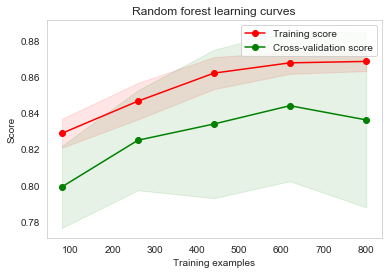

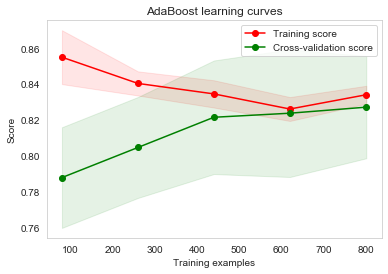

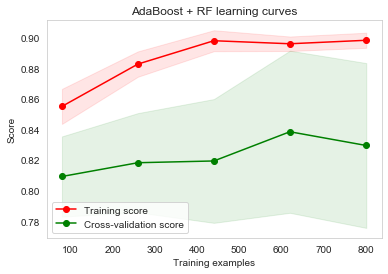

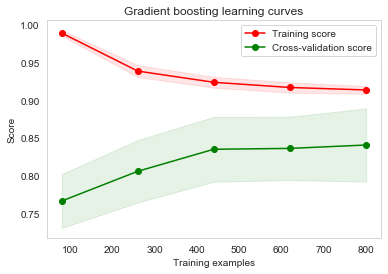

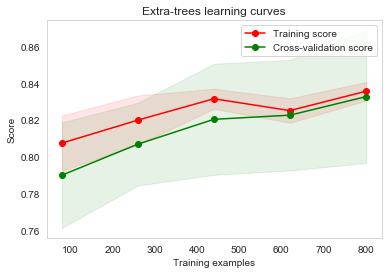

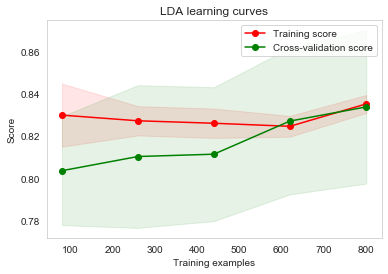

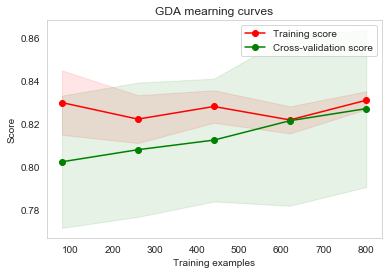

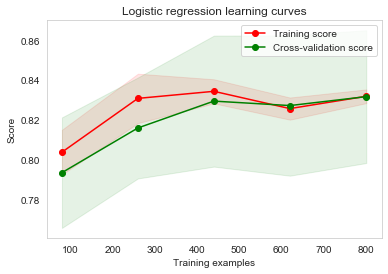

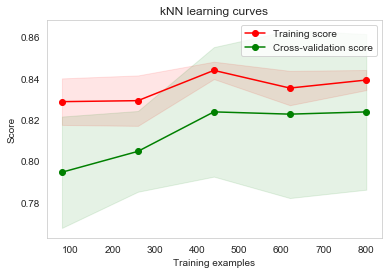

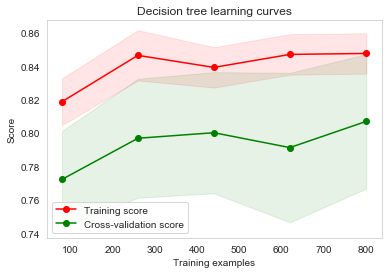

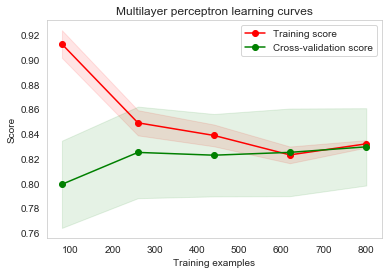

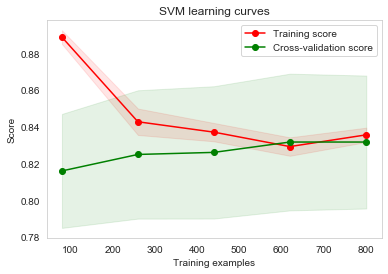

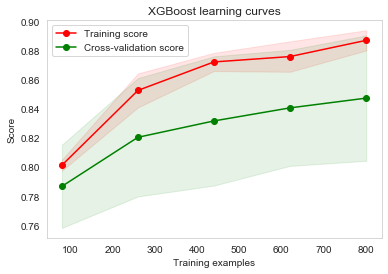

In [78]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve
    """
    plt.figure()
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
    
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

p = plot_learning_curve(rf_best, "Random forest learning curves", X_train, Y_train, cv=kfold, n_jobs=-1)
p = plot_learning_curve(ada_best, "AdaBoost learning curves", X_train, Y_train, cv=kfold, n_jobs=-1)
p = plot_learning_curve(ada_rf_best, "AdaBoost + RF learning curves", X_train, Y_train, cv=kfold, n_jobs=-1)
p = plot_learning_curve(gb_best, "Gradient boosting learning curves", X_train, Y_train, cv=kfold, n_jobs=-1)
p = plot_learning_curve(et_best, "Extra-trees learning curves", X_train, Y_train, cv=kfold, n_jobs=-1)
p = plot_learning_curve(lda_best, "LDA learning curves", X_train, Y_train, cv=kfold, n_jobs=-1)
p = plot_learning_curve(qda_best, "GDA mearning curves", X_train, Y_train, cv=kfold, n_jobs=-1)
p = plot_learning_curve(lr_best, "Logistic regression learning curves", X_train, Y_train, cv=kfold, n_jobs=-1)
p = plot_learning_curve(knn_best, "kNN learning curves", X_train, Y_train, cv=kfold, n_jobs=-1)
p = plot_learning_curve(dt_best, "Decision tree learning curves", X_train, Y_train, cv=kfold, n_jobs=-1)
p = plot_learning_curve(nn_best, "Multilayer perceptron learning curves", X_train, Y_train, cv=kfold, n_jobs=-1)
p = plot_learning_curve(svm_best, "SVM learning curves", X_train, Y_train, cv=kfold, n_jobs=-1)
#p = plot_learning_curve(GaussianNB, "Gaussian naive bayes classifier learning curves", X_train, Y_train, cv=kfold, n_jobs=-1)
#p = plot_learning_curve(GaussianNB, "SVM learning curves", X_train, Y_train, cv=kfold, n_jobs=-1)
p = plot_learning_curve(xgb_best, "XGBoost learning curves", X_train, Y_train, cv=kfold, n_jobs=-1)

##  Feature importance

AttributeError: 'Pipeline' object has no attribute 'feature_importances_'

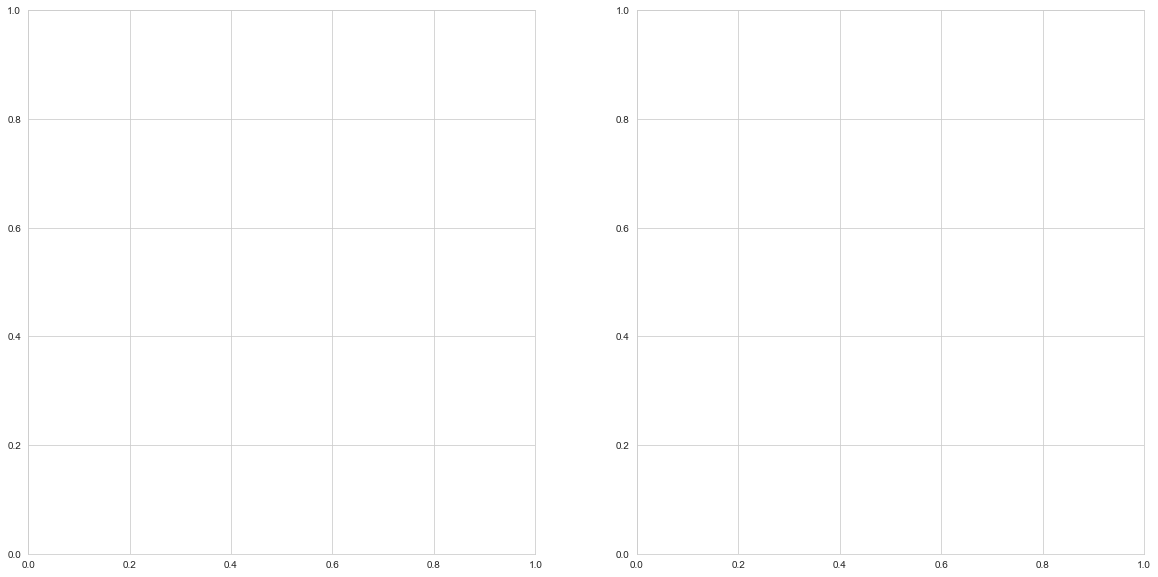

In [79]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex="all", figsize=(20,10))

names_classifiers = [("RandomForest",rf_best),("GradientBoosting",gb_best)]

nclassifier = 0

for col in range(2):
    name = names_classifiers[nclassifier][0]
    classifier = names_classifiers[nclassifier][1]
    indices = np.argsort(classifier.feature_importances_)[::-1][:40]
    p = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[col])
    p.set_xlabel("Relative importance",fontsize=12)
    p.set_ylabel("Features",fontsize=12)
    p.tick_params(labelsize=9)
    p.set_title(name + " feature importance")
    nclassifier += 1

## Prediction diffrences among models

In [ ]:
test_Survived_lr = pd.Series(lr_best.predict(test_final), name="LR")
test_Survived_nn = pd.Series(nn_best.predict(test_final), name="NN")
test_Survived_gb = pd.Series(gb_best.predict(test_final), name="GB")
test_Survived_knn = pd.Series(knn_best.predict(test_final), name="kNN")
test_Survived_rf = pd.Series(rf_best.predict(test_final), name="RF")
test_Survived_svn = pd.Series(svm_best.predict(test_final), name="SVN")
test_Survived_xgb = pd.Series(xgb_best.predict(test_final), name="XGB")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_lr, 
                              test_Survived_nn, 
                              test_Survived_gb,
                              test_Survived_knn,
                              test_Survived_rf,
                              test_Survived_svn,
                              test_Survived_xgb
                             ], axis=1)


p = sns.heatmap(ensemble_results.corr(),annot=True)

## Ensamble modeling

In [ ]:
voting = VotingClassifier(estimators=[('lr', lr_best), 
                                      ('nn', nn_best), 
                                      ('gb', gb_best), 
                                      ('knn', knn_best), 
                                      ('rf', rf_best), 
                                      ('svm', svm_best),
                                      ('xgb', xgb_best)
                                     ], voting='soft', n_jobs=-1)

voting = voting.fit(X_train, Y_train)

## Final prediction

In [ ]:
test_Survived = pd.Series(voting.predict(test_final), name="Survived")
#test_Survived = pd.Series(xgb_best.predict(test_final), name="Survived")

results = pd.concat([test["PassengerId"], test_Survived], axis=1)

results.to_csv("ensemble_python_voting.csv",index=False)